In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
def read_out_tr(out_filename):
    col = ["events", "time", "from_node", "to_node", "pkt_type", "pkt_size", "flags", "fid", "src_addr", "dst_addr", "seq_num", "pkt_id"]
    df = pd.read_csv(out_filename, sep = ' ', header = None)
    df.columns = col
    return df

def get_tcp_packets(df):
    df_out = df.loc[df["pkt_type"].isin(["tcp"])]
    return df_out

def parse_trace(file):
    col = ["tmp_pkts", "flow duration", "fin_fid", "rtt times", \
               "group_id", "Tw_", "Tp_", "Np_", "?1", "?2", "?3", "?4", "?5", "Average rate", "start time"]
    df = pd.read_csv(file, sep = ' ', header = None)
    df.columns = col
    df["Normalized FCT"] = 40 * 1e9  / df["Average rate"]
    return df

def humanbytes(B):
    B = float(B)
    KB = float(1000)
    MB = float(KB ** 2)
    GB = float(KB ** 3)
    TB = float(KB ** 4) 

    if B < KB:
        return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
    elif KB <= B < MB:
        return '{0:.2f} KB'.format(B/KB)
    elif MB <= B < GB:
        return '{0:.2f} MB'.format(B/MB)
    elif GB <= B < TB:
        return '{0:.2f} GB'.format(B/GB)
    elif TB <= B:
        return '{0:.2f} TB'.format(B/TB)
    
def plot_one_end2end_delay_mean_flowsize(out_filename, flow_size, tracefile, alg):
    raw_data = read_out_tr(out_filename)
    tcp_pkts = get_tcp_packets(raw_data)
    grouped = tcp_pkts.groupby(['fid', 'pkt_id'])
    fid_pkt_delay = (grouped.last()['time'] - grouped.first()['time'])* 1e6
    trace_df = parse_trace(tracefile)
    fid_delay = fid_pkt_delay.sum(level='fid')
    trace_df['flow_delay'] = trace_df["fin_fid"].apply(lambda x: fid_delay[int(x)])
    flow_delay = trace_df[['tmp_pkts', 'fin_fid', 'flow_delay']]
    cate=pd.cut(flow_delay["tmp_pkts"], flow_size, labels=flow_size[:-1])
    delay_average = []
    for label in flow_size[:-1]:
        seg_flow_delay = flow_delay[cate == label]
        delay_average.append(seg_flow_delay.mean()['flow_delay'])
    
    plt.plot([humanbytes(i*1500) for i in flow_size[:-1]], delay_average, label=alg)
    return delay_average
    
def plot_end2end_delay_mean_flowsize(flow_size, algs):
    directory = "/home/ovs2/eval/tcp_random_pair_32host/diff_host_4pods/4host_FID/out_tr/4p4h1000f/"
    plt.figure(figsize=(18,5))
    plt.xlabel('flow size')
    plt.ylabel('delay average(us)')
    plt.title("delay average at load 0.9")
    plot_data = []
    for alg in algs:
        filename = '4p4h1000f_'+alg+'_out.tr'
        tracefile = "/home/ovs2/eval/tcp_random_pair_32host/diff_host_4pods/4host_FID/tcp-incast-"+alg+"/tcp_flow_1000_0.9_Topology-4hosts-4pods-random.tcl.tr"
        plot_data.append(plot_one_end2end_delay_mean_flowsize(directory+filename, flow_size, tracefile, alg))
    plt.legend()
    plt.show()
    return plot_data

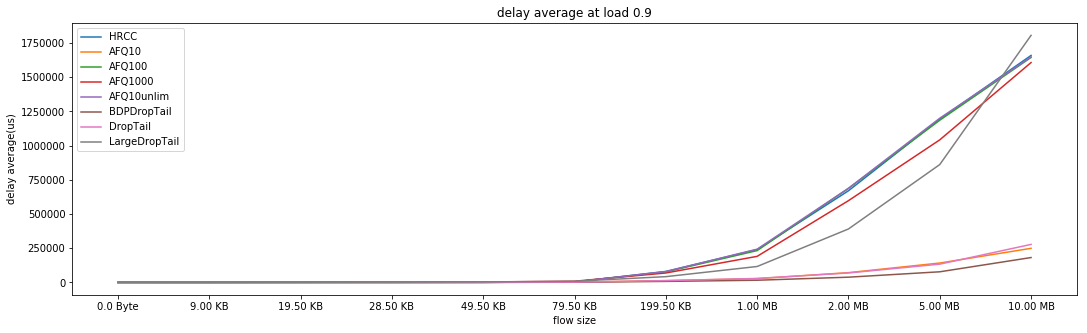

In [3]:
algs = ['HRCC', 'AFQ10', 'AFQ100', 'AFQ1000', 'AFQ10unlim', 'BDPDropTail', 'DropTail', 'LargeDropTail']
flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, 20000, float('inf')]
plot_data = plot_end2end_delay_mean_flowsize(flow_size, algs)


In [4]:
plot_data

[[91.3090909090884,
  125.39622641503857,
  216.71428571423314,
  350.5473684211175,
  760.2936507937472,
  3767.9344262293935,
  80627.63461538494,
  240538.19191919264,
  670172.2272727266,
  1193811.6750000005,
  1659448.0526315712,
  nan],
 [76.77575757574752,
  109.75471698105594,
  173.80219780229103,
  278.8736842106115,
  490.59523809531015,
  2036.524590163781,
  13197.74038461521,
  27697.74747474792,
  71706.9886363636,
  142004.73749999935,
  249497.63157894425,
  nan],
 [139.5030303030127,
  186.56603773573394,
  347.87912087905306,
  554.0210526316165,
  1031.2063492062484,
  3971.459016393336,
  76986.82692307583,
  232938.2929292935,
  687477.2272727262,
  1185810.1625,
  1644773.9999999835,
  nan],
 [544.5333333332806,
  590.4339622641721,
  1297.6263736262963,
  2049.052631579102,
  3446.2301587301604,
  9019.557377048692,
  69130.97115384798,
  190853.4040404039,
  597823.9318181848,
  1042311.3999999976,
  1607330.1052631314,
  nan],
 [87.33333333334029,
  121.39622

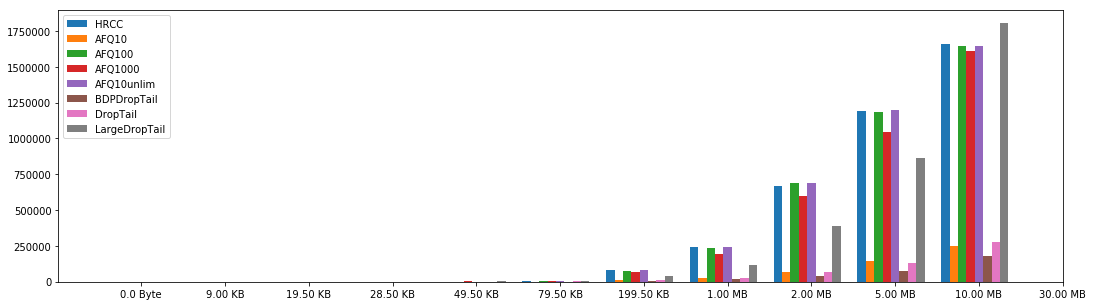

In [13]:
algs = ['HRCC', 'AFQ10', 'AFQ100', 'AFQ1000', 'AFQ10unlim', 'BDPDropTail', 'DropTail', 'LargeDropTail']
bar_width=0.1
plt.figure(figsize=(18,5))
tick_label=[humanbytes(i*1500) for i in flow_size[:-1]]
x=np.arange(len(flow_size[:-1]))
index = 0
for alg in algs:
    plt.bar(x,plot_data[index],bar_width,label=alg)
    index+=1
    x = x + bar_width


plt.legend()
x=np.arange(len(flow_size[:-1]))
plt.xticks(x+len(algs)*bar_width/2,tick_label)
plt.show()